In [3]:
# importing the libraries
import peakutils
import numpy as np
from peakutils.plot import plot as pplot
import matplotlib.pyplot as plt
from pyearth import Earth

In [4]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx


def loaddata(data_filename):
    """load matrix data"""
    data = np.genfromtxt(data_filename, delimiter='\t')
    data_nm = data[1:,0]    #wavelength in nm
    data_time = data[0,1:]
    data_z = data[1:, 1:]

    return data_nm, data_time, data_z


def loaddata_timeslice(data_filename):
    """load array data"""
    data = np.genfromtxt(data_filename, delimiter='\t')
    data_nm = data[:,0]    #wavelength in nm
    data_z_array = data[:, 1]

    return data_nm, data_z_array

In [5]:
def add_noise(nm_array, y_array, noise_coefficient):
    # Add noise
    np.random.seed(1800)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    y_proc = y_array + y_noise
    
    return y_proc

In [6]:
#adapted from Jing
def Earth_Smoothing(nm_array, y_array):        
    """
    ============================================
     Plotting derivatives of simple sine function
    ============================================

     A simple example plotting a fit of the sine function
    and the derivatives computed by Earth.
    
    Notes
    -----   
    generates a denoise curve from the TA data
    Parameters
    ----------
        nm_array: wavelength array
        timedelay: time delay array
        noise_coefficient: the noise coefficients that user want to generate
    Returns
    -------
        a smoothing curve from the original noise curve   
    """

    
   # Fit an Earth model
    model = Earth(smooth=True)
    model.fit(nm_array, y_array)

   # Print the model
    #print(model.trace())
    #print(model.summary())

   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)

    # Plot true and predicted function values 
    #plt.figure(figsize=(15,8))
    #plt.title('Peak Smoothening', fontsize = 16, fontweight = 'bold')
    #plt.xlabel('Wavelength (nm)', fontsize = 16, fontweight = 'bold')
    #plt.ylabel('Time delay (ps)', fontsize = 16, fontweight = 'bold')
    #plt.xticks(fontsize = 14)
    #plt.yticks(fontsize = 14)
    #plt.plot(nm_array, y_array, 'r', label = 'add noise')
    #plt.plot(nm_array, y_hat, 'b', label = 'after Earth')
    #plt.ylabel('function')
    
    return  y_hat

* Loading data array

In [7]:
array_filename = 'twogaussian_array.txt'
datanm, dataz = loaddata_timeslice(array_filename)

* Add noise to synthetic data

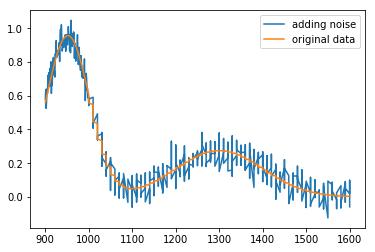

In [8]:
noisyz = add_noise(datanm, dataz, 0.05)
plt.figure()
plt.plot(datanm, noisyz, label = 'adding noise')
plt.plot(datanm, dataz, label = 'original data')
plt.legend()

### Generate a matrix of data that has various noise level ###

In [26]:
def noisyz_matx(nm, z, noise_coeff):
    noisyz_matx = np.empty((len(nm), len(noise_coeff)))
    for i in range(len(noise_coeff)):
        noisyz = add_noise(nm, z, noise_coeff[i])
        noisyz_matx[:, i] = noisyz
        plt.figure()
        plt.plot(nm, noisyz)
        plt.plot(nm, z)
    
    return noisyz_matx

/Users/demiliu/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


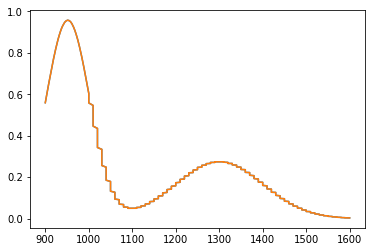

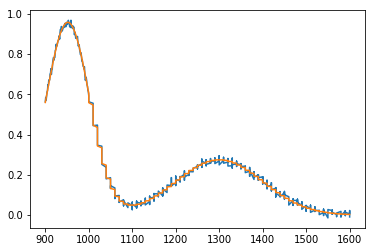

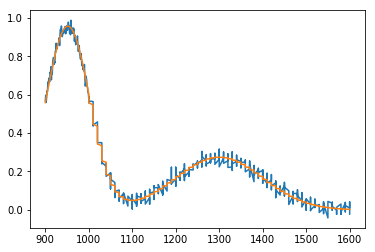

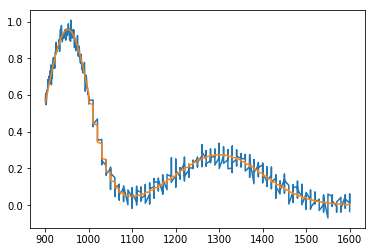

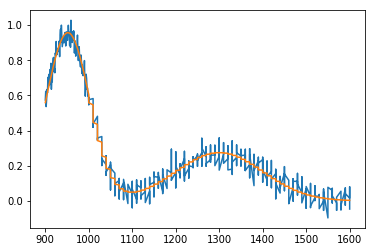

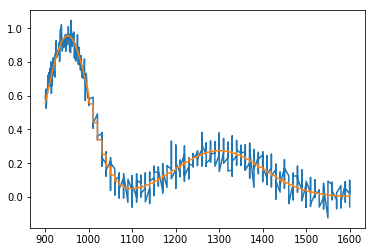

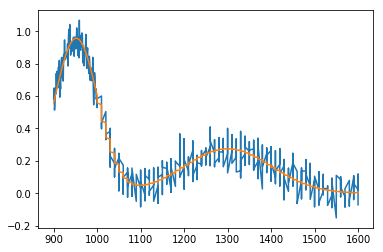

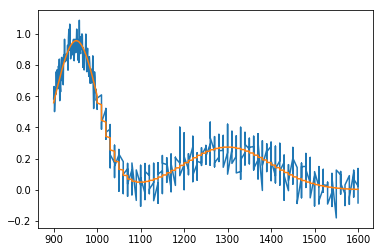

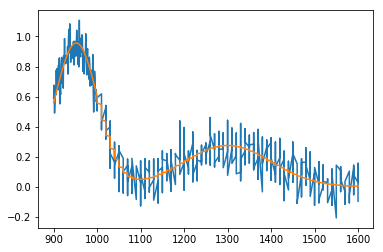

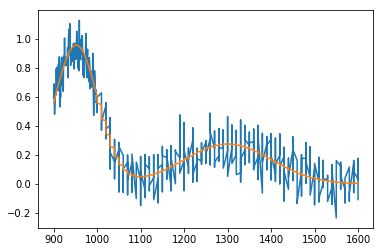

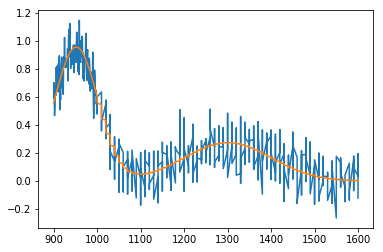

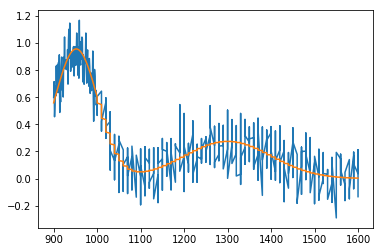

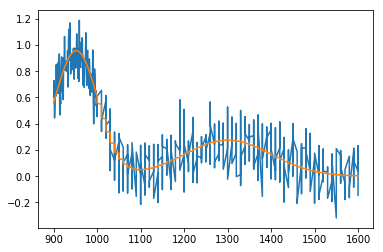

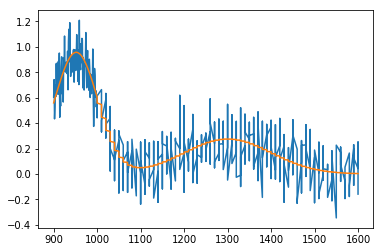

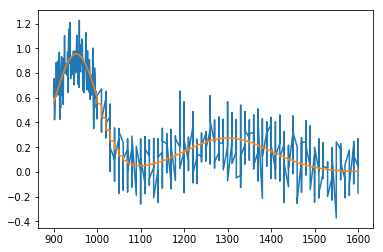

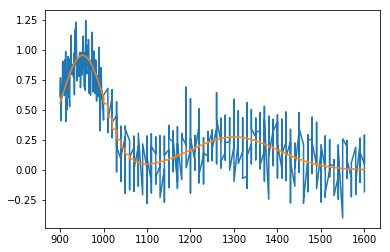

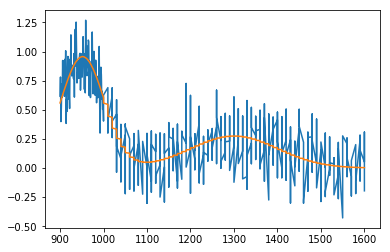

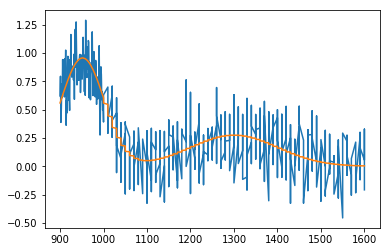

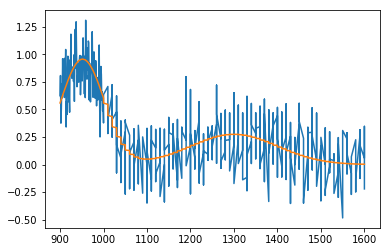

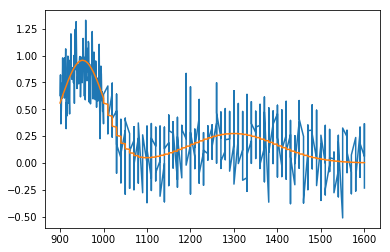

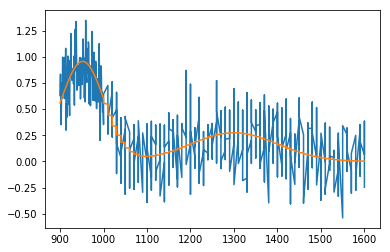

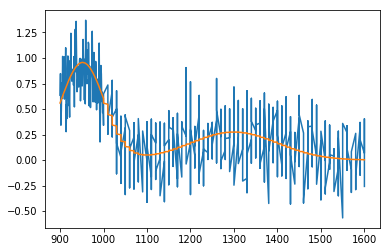

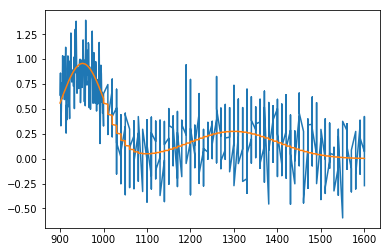

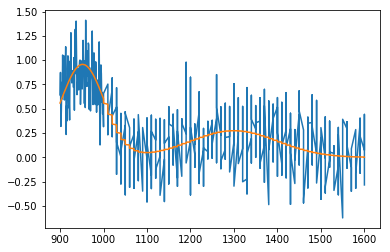

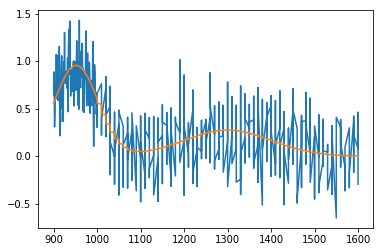

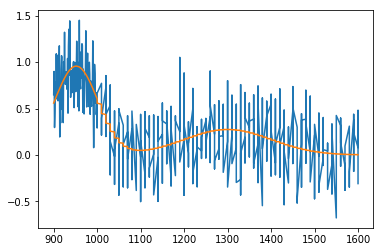

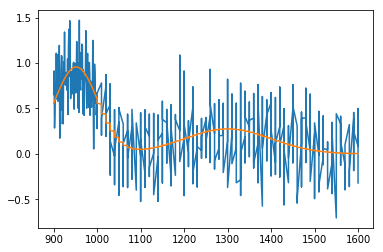

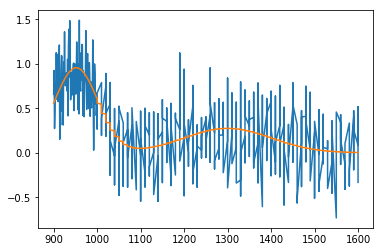

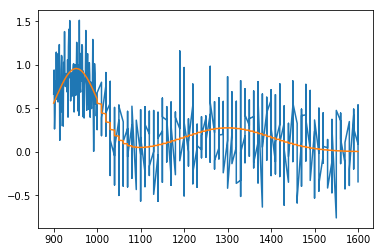

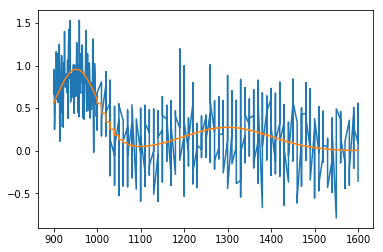

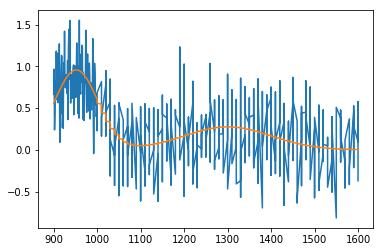

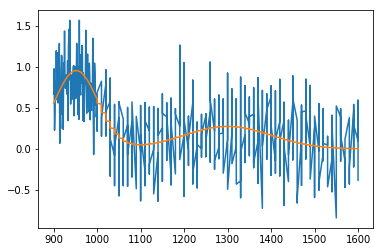

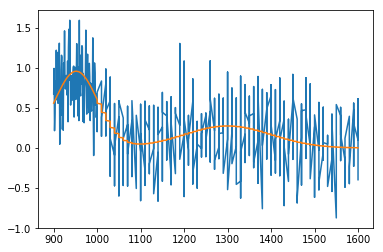

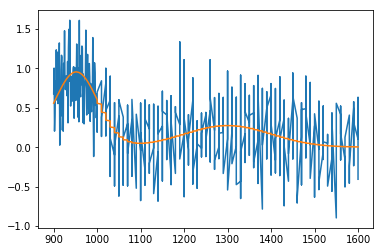

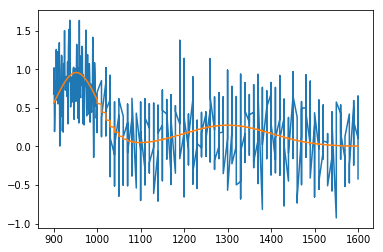

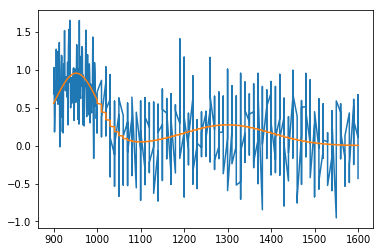

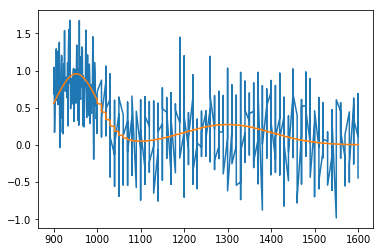

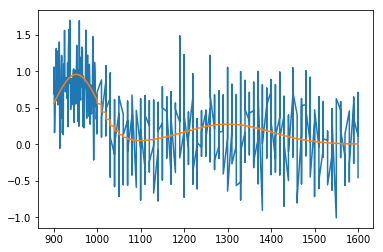

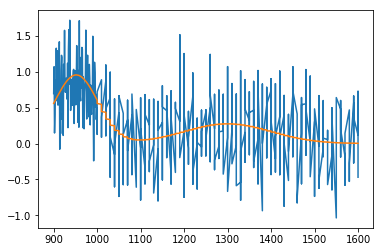

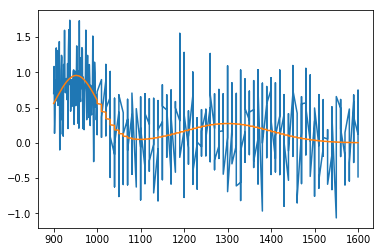

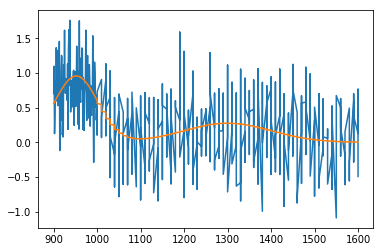

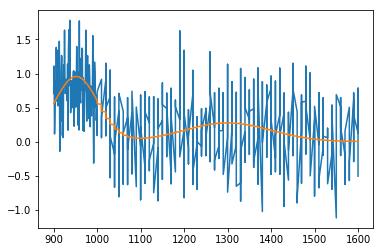

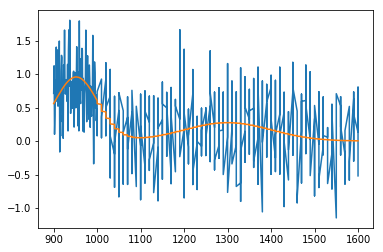

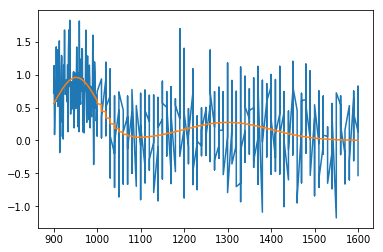

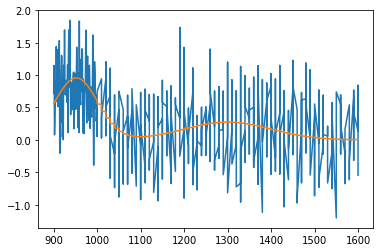

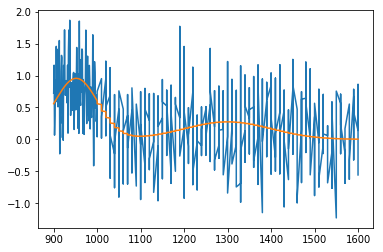

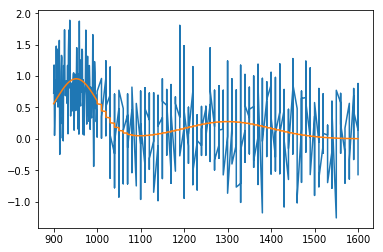

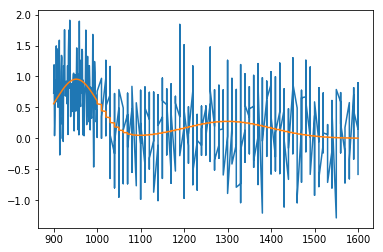

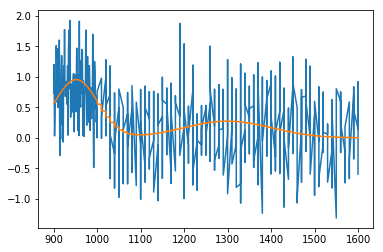

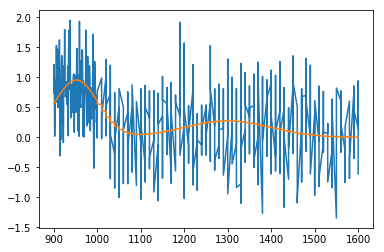

In [76]:
noise_coeff_array = np.arange(0, 0.5, 0.01)
noisy_matx = noisyz_matx(datanm, dataz, noise_coeff_array)
array_num = len(noise_coeff_array)

In [77]:
true_peak = findpeak(dataz, 0, 300)

In [78]:
findpeak(dataz, 0, 300)

array([ 51, 400])

### Smooth the data ###

In [80]:
def smooth_matrix(nm_array,data_matrix):
    num_array = np.shape(data_matrix)[1]
    smooth_matx = np.empty_like(data_matrix)
    for i in range(num_array):
        data_array = data_matrix[:, i]
        smooth_array = Earth_Smoothing(nm_array, data_array)
        smooth_matx[:, i] = smooth_array
    
    return smooth_matx

In [81]:
smooth_matx = smooth_matrix(datanm, noisy_matx)

/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


## Find peaks after smothening ##

In [13]:
def findpeak(data_z_array, threshold, min_dist):
    """find peaks and return indices of the peaks"""    
    peak_indices = peakutils.indexes(data_z_array, thres=threshold, min_dist=min_dist)
    
    return peak_indices


In [39]:
def peak_matrix(nm_array, data_matrix, threshold, mindist):
    """find peaks in a data matrix"""
    peak_idx_matx = np.zeros((np.shape(data_matrix)[1],2))
    
    for i in range(np.shape(data_matrix)[1]):
        data_timeslice = data_matrix[:, i]        
        peak_idx = findpeak(data_timeslice, threshold, mindist)        
        peak_idx_matx[i, :] = peak_idx

        
    return peak_idx_matx

In [84]:
peak_idx_matx = peak_matrix(datanm, noisy_matx, 0, 350)
peak_idx_matx

array([[ 51.,  51.],
       [ 59., 413.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 429.],
       [ 59., 548.],
       [ 59., 548.],
       [ 59., 548.],
       [ 37., 398.],
       [ 37., 398.],
       [ 37., 398.],
       [ 37., 398.],
       [ 37., 398.],
       [ 37., 398.],
       [ 37., 398.],
       [ 37., 548.],
       [ 37., 548.],
       [ 37., 548.],
       [ 37., 548.],
       [ 37., 548.],
       [ 37., 548.],
       [ 37., 548.],
       [ 37., 548.],
       [ 37.,

## Calculate error rate ##
### - can define the tolerance level of error ###
### - error rate = # of time-slices with correct peak position / total # of time-slices ###

In [72]:
def peakpos_error(true_pos, pos_output, tol):
    error = 0
    array_nums = np.shape(true_pos)[0]
    for i in range(array_num):
        check = np.allclose(true_pos[i, :], pos_output[i, :], atol = tol)
        if check == True:
            error = error
        elif check == False:
            error += 1
    error_rate = error / array_nums
    return error_rate

In [85]:
true_pos = np.tile(true_peak, (array_num, 1))
tolerance = 70
peakpos_error(true_pos, peak_idx_matx, tolerance)

0.3

## Calculate the peak position difference ##

In [87]:
def peakpos_error_array(true_pos, pos_output):
    error = true_pos - pos_output
    res = error ** 2 / true_pos

    return res            

In [89]:
true_pos_array = np.array([10, 20])
pos_output_array = np.array([10, 30])

peakpos_error_array(true_pos_array, pos_output_array)

array([0., 5.])

In [94]:
def peakpos_error_matrix_bypeak(true_pos, pos_output):
    num_array = np.shape(true_pos)[0]
    error_matx = np.empty_like(true_pos)
    for i in range(num_array):
        error = peakpos_error_array(true_pos[i, :], pos_output[i, :])
        error_matx[i, :] = error
    
    return error_matx
        

In [99]:
error_matx = peakpos_error_matrix_bypeak(true_pos, peak_idx_matx)

## Evaluate how noise-level affects smoothening/peak-finding accuracy ##

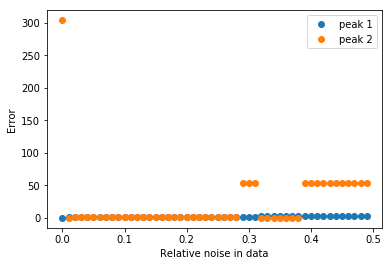

In [98]:
peak1_error = error_matx[:, 0]
peak2_error = error_matx[:, 1]

plt.figure()
plt.xlabel('Relative noise in data')
plt.ylabel('Error')
plt.plot(noise_coeff_array, peak1_error, 'o', label = 'peak 1')
plt.plot(noise_coeff_array, peak2_error, 'o', label = 'peak 2')
plt.legend()

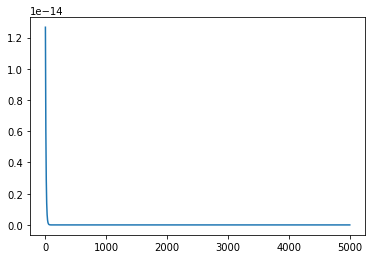

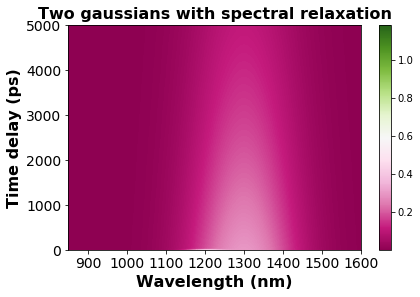

In [107]:
from astropy.modeling import models, fitting
import syntheticdata
def astropy_smoothing(nm_array, timedelay, noise_coefficient,gg_init):
    # Generate fake data
    np.random.seed(42)
    ydata = timedelay + noise_coefficient*np.random.normal(size=nm_array.size)
    # Now to fit the data create a new superposition with initial
    # guesses for the parameters:
    fitter = fitting.SLSQPLSQFitter()
    gg_fit = fitter(gg_init, nm_array, ydata)

    # Plot the data with the best-fit model
    plt.figure(figsize=(50,40))
    plt.subplot(311)
    plt.title('Smoothening data', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.plot(nm_array, ydata, 'ko')
    plt.plot(nm_array, gg_fit(nm_array), color='blue')


    plt.subplot(312)
    plt.title('True data', fontsize = 30, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.plot(nm_array,timedelay,color='red')
    plt.plot(nm_array,gg_fit(nm_array), color='blue')
    
    plt.subplot(313)
    plt.title('data differ',fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 15, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 30, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 30, fontweight = 'bold')
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0, color='red', linestyle='-')
    plt.plot(nm_array,timedelay-gg_fit(nm_array), color='blue')
    ## Find peaks in data matrix after smothening ##
    return gg_fit(nm_array)

In [104]:
def peak_finding(x,y):
    indexes = peakutils.indexes(y, thres=0, min_dist=50)
    print(indexes)
    print(x[indexes], y[indexes])
    plt.figure(figsize=(20,5))
    pplot(x, y, indexes)
    plt.title('First estimate', fontsize = 15, fontweight = 'bold')
    plt.xlabel('Wavelength (nm)', fontsize = 15, fontweight = 'bold')
    plt.ylabel('Time delay (ps)', fontsize = 15, fontweight = 'bold')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.226274822602005
            Iterations: 17
            Function evaluations: 141
            Gradient evaluations: 17
[100 450]
[ 950 1300] [1.00065625 0.3       ]
[100 445]
[ 950 1295] [0.9998227  0.29295874]


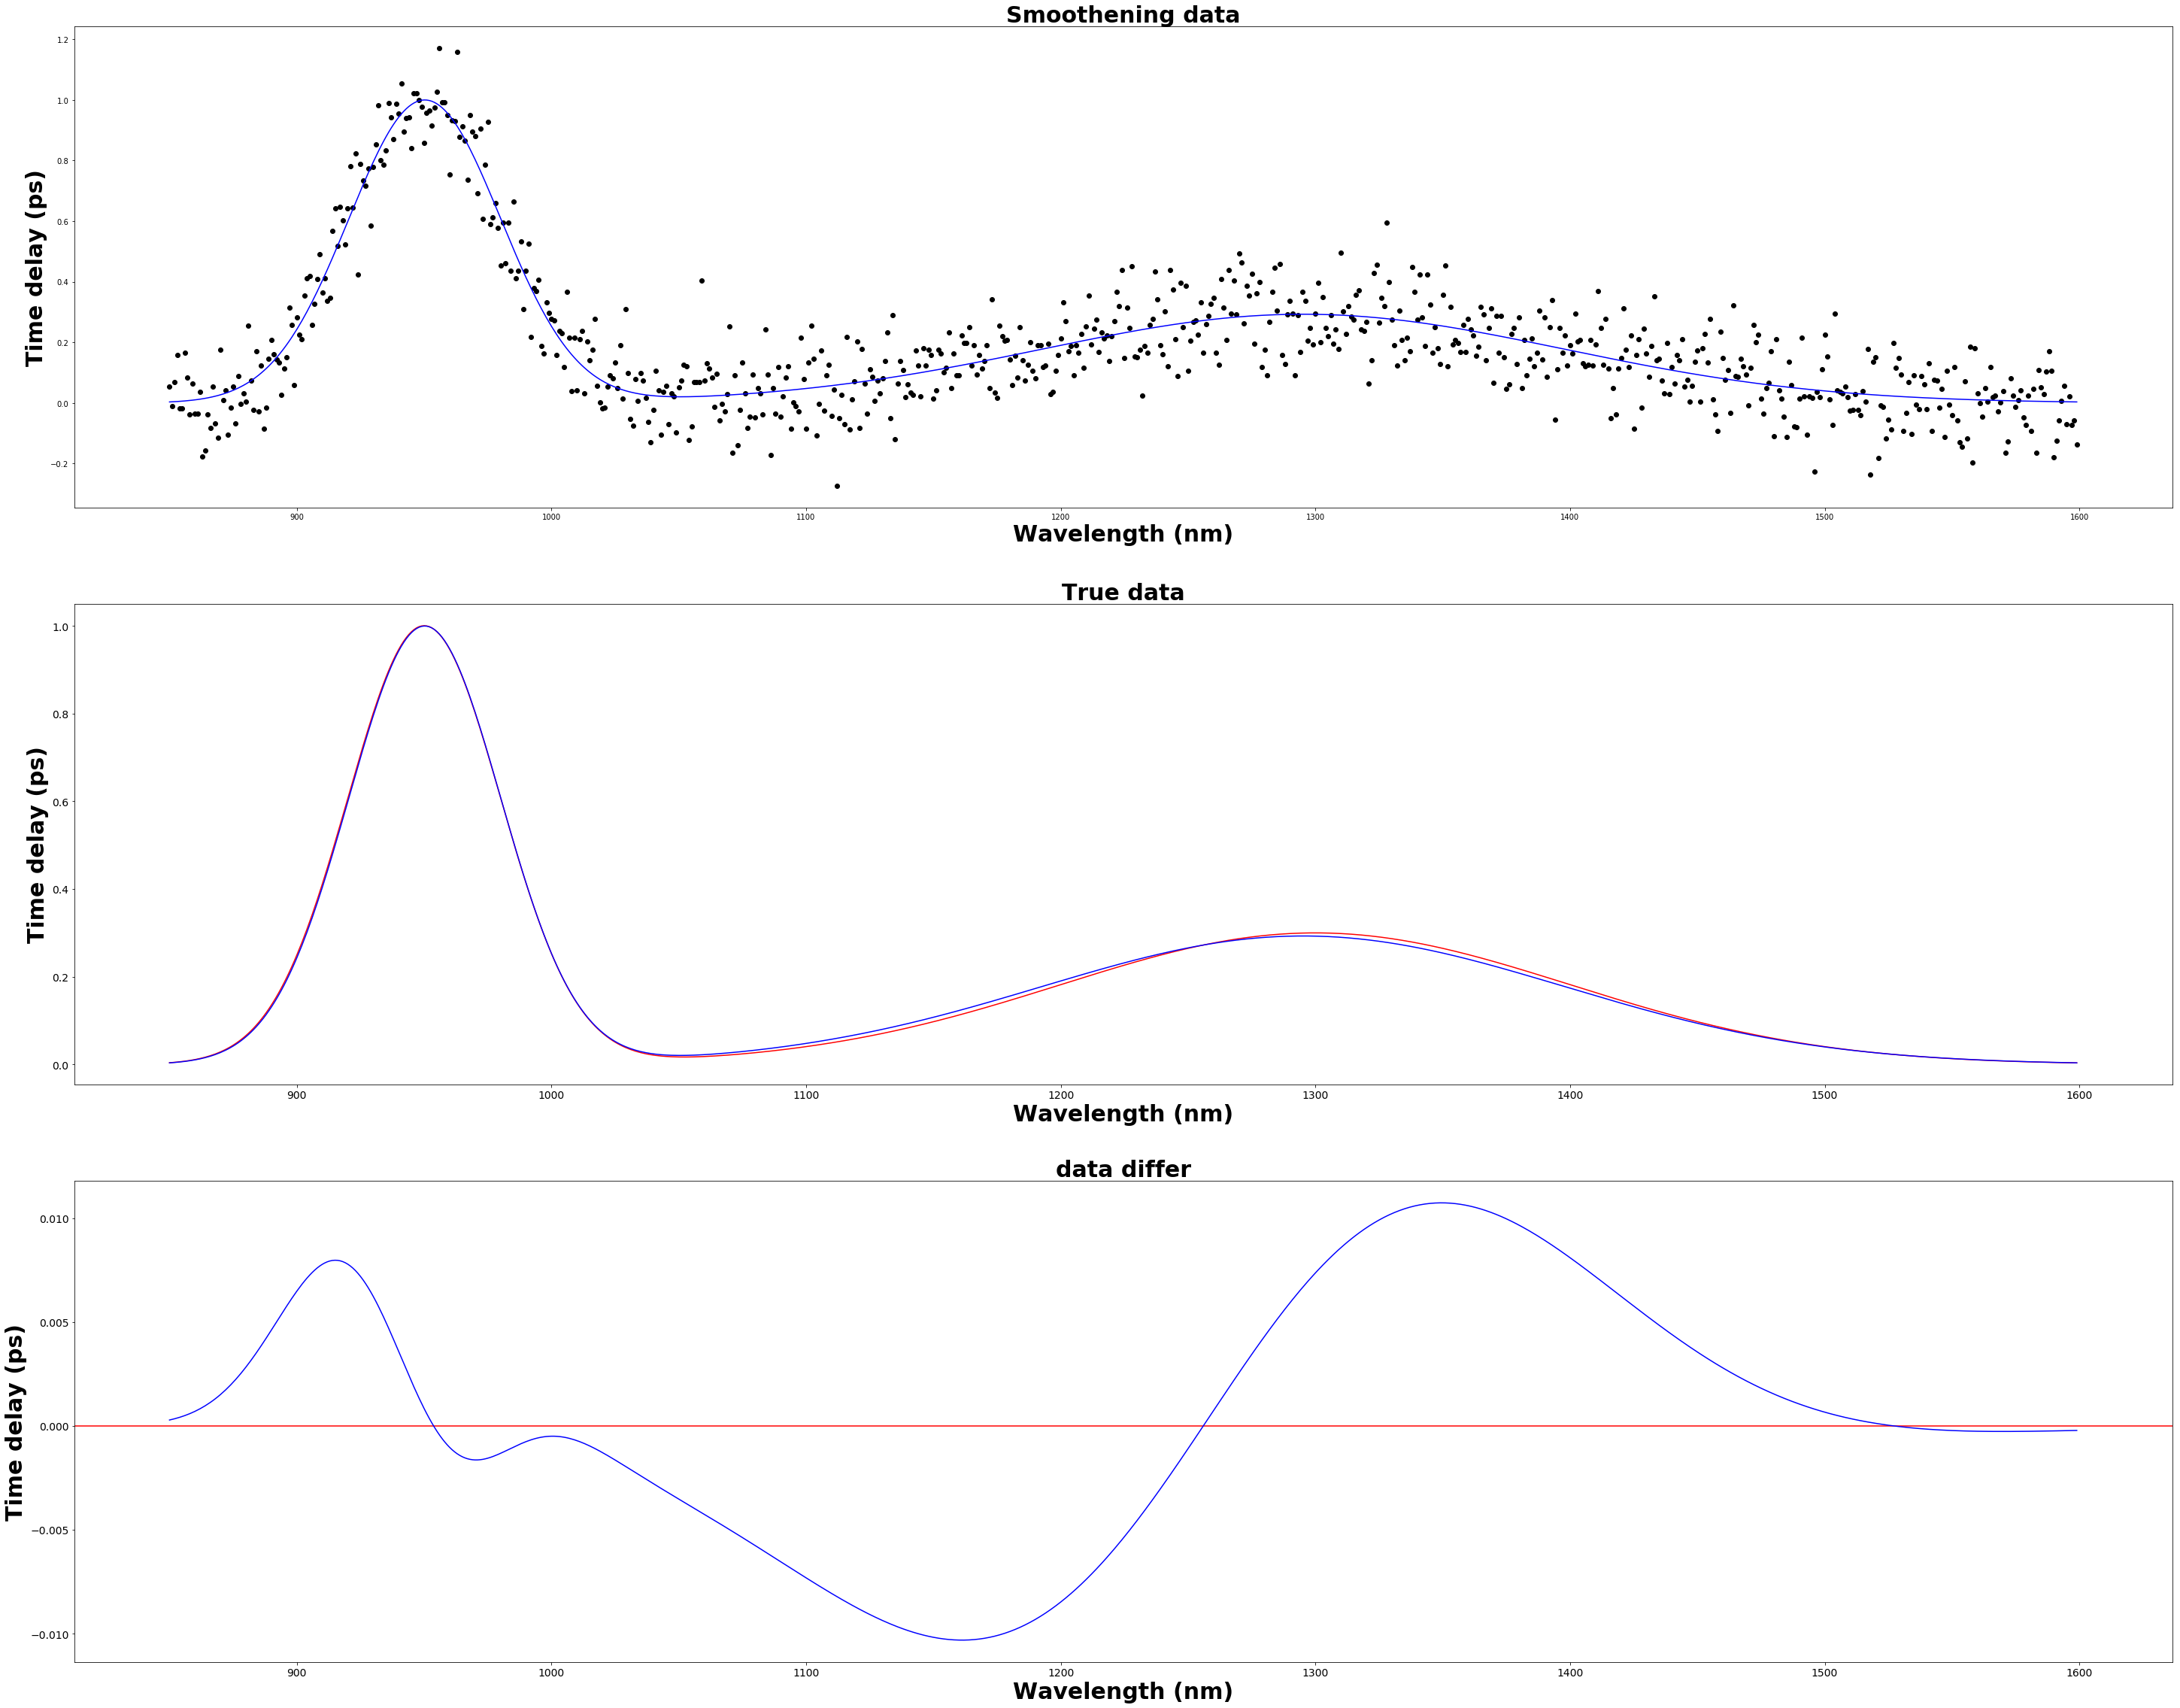

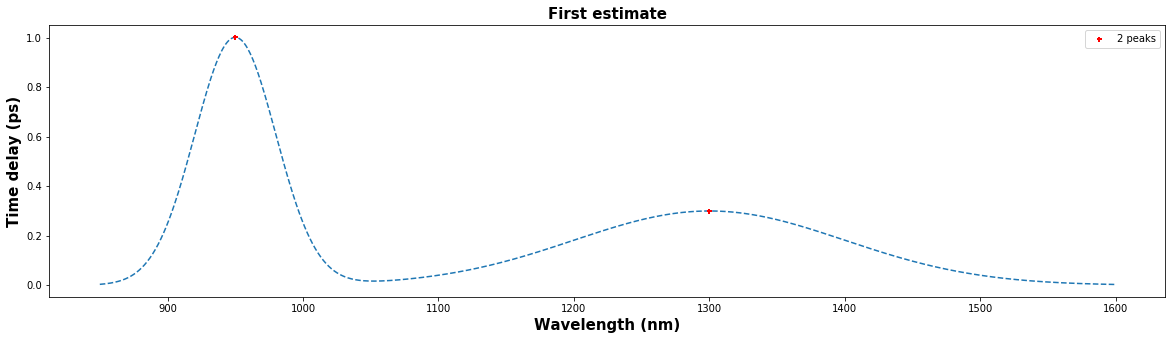

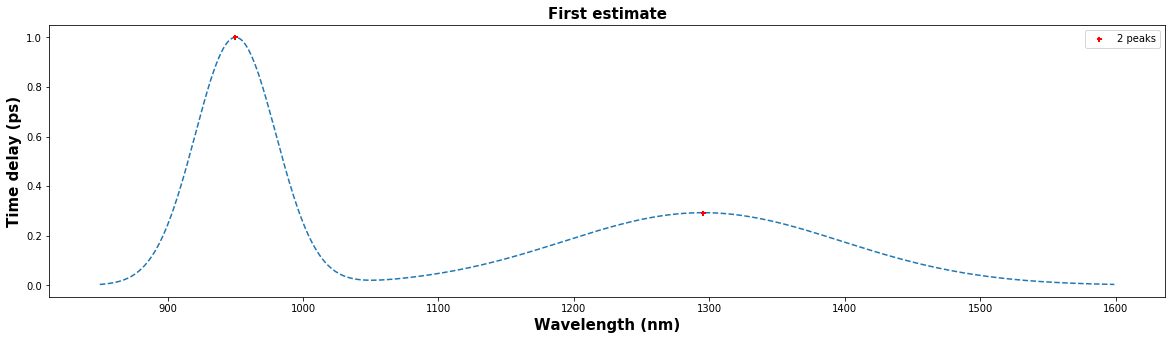

In [108]:
g1 = models.Gaussian1D(1, 950, 30)
g2 = models.Gaussian1D(0.3, 1300, 100)
gg_init = g1+g2

nm_array = syntheticdata.nm
timedelay = (syntheticdata.species_1 + syntheticdata.species_2)
noise_coefficient =0.1
ysmooth1 = astropy_smoothing(nm_array, timedelay, noise_coefficient,gg_init)
peak_finding(nm_array,timedelay)
peak_finding(nm_array,ysmooth1)